In [ ]:
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
import mne
import scipy.io
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import pywt
import warnings
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=RuntimeWarning)


def extract_intervals(mask_row):
    intervals = []
    in_seizure = False
    start = 0
    for i, val in enumerate(mask_row):
        if val == 1 and not in_seizure:
            start = i
            in_seizure = True
        elif val == 0 and in_seizure:
            intervals.append((start * 10, i * 10))  # convert window index to seconds
            in_seizure = False
    if in_seizure:
        intervals.append((start * 10, len(mask_row) * 10))
    return intervals


def load_annotations(annotation_path):
    mat = scipy.io.loadmat(annotation_path)
    raw_annots = mat["annotat_new"][0]
    seizure_map = {}
    for i, annot in enumerate(raw_annots):
        if annot.shape[0] < 2:
            continue
        edf_name = f"eeg{i+1}.edf"
        mask = annot[1].squeeze()
        intervals = extract_intervals(mask)
        seizure_map[edf_name] = intervals
    return seizure_map

def parse_zenodo_json(json_path):
    if not os.path.exists(json_path):
        print("zenodo_annotations.json not found. Attempting to create from annotations_2017.mat...")
        seizure_map = load_annotations("C:/Users/karti/Downloads/EEG_images/zenodo/annotations_2017.mat")

        json_data = []
        for edf_file, intervals in seizure_map.items():
            seizure_pairs = [(int(start), int(end)) for start, end in intervals]
            json_data.append({"file": edf_file, "seizure_times": seizure_pairs})
        with open(json_path, "w") as f:
            json.dump(json_data, f, indent=2)
        print("zenodo_annotations.json created.")

    with open(json_path, 'r') as f:
        entries = json.load(f)

    seizure_data = []
    for entry in entries:
        file = entry["file"]
        for (start, end) in entry["seizure_times"]:
            seizure_data.append({
                "edf_file": file,
                "recording_start": 0,
                "recording_end": int(end) + 30,
                "seizure_start": int(start),
                "seizure_end": int(end),
                "preseizure_start": max(int(start) - 900, 0)
            })
    return seizure_data


def extract_channels_mne(file_path, channels=4):
    try:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        data, times = raw.get_data(return_times=True)
        return data[:channels]
    except Exception as e:
        print(f"⚠ Skipping file {file_path} due to error: {e}")
        return None

def extract_features(signal, fs=256):
    feats = []
    for ch in signal:
        # Time domain
        mean_val = np.mean(ch)
        std_val = np.std(ch)
        min_val = np.min(ch)
        max_val = np.max(ch)
        q25 = np.percentile(ch, 25)
        q75 = np.percentile(ch, 75)

        # Frequency domain (Welch PSD)
        freqs, psd = welch(ch, fs=fs)
        band_power = lambda fmin, fmax: np.sum(psd[(freqs >= fmin) & (freqs < fmax)])
        delta = band_power(0.5, 4)
        theta = band_power(4, 8)
        alpha = band_power(8, 13)
        beta = band_power(13, 30)
        gamma = band_power(30, 45)

        # Entropy
        hist, _ = np.histogram(ch, bins=50, density=True)
        hist += 1e-12
        shannon = -np.sum(hist * np.log2(hist))

        # Wavelet energy
        coeffs = pywt.wavedec(ch, 'db4', level=3)
        wavelet_energies = [np.sum(np.square(c)) for c in coeffs]

        feats.extend([
            mean_val, std_val, min_val, max_val, q25, q75,
            delta, theta, alpha, beta, gamma,
            shannon, *wavelet_energies
        ])
    return feats

def segment_and_extract(data, info, fs=500, window_sec=10):
    window_size = fs * window_sec
    total_windows = data.shape[1] // window_size
    X, y = [], []

    for i in range(total_windows):
        start = i * window_size
        end = start + window_size
        global_time = info["recording_start"] + start // fs

        if info["seizure_start"] <= global_time < info["seizure_end"]:
            label = 2
        elif info["preseizure_start"] <= global_time < info["seizure_start"]:
            label = 1
        else:
            label = 0

        segment = data[:, start:end]
        X.append(extract_features(segment))
        y.append(label)

    return np.array(X), np.array(y)

# -----------------------------
# 3. Dataset Builder
# -----------------------------
def build_dataset(summary_data, edf_folder):
    X_all, y_all = [], []
    for info in summary_data:
        edf_path = os.path.join(edf_folder, info["edf_file"])
        if not os.path.exists(edf_path):
            print(f"Missing EDF: {edf_path}")
            continue
        data = extract_channels_mne(edf_path)
        if data is None:
            continue
        try:
            X, y = segment_and_extract(data, info)
            X_all.append(X)
            y_all.append(y)
        except Exception as e:
            print(f"Error in {info['edf_file']}: {e}")
    if not X_all:
        return None, None
    return np.concatenate(X_all), np.concatenate(y_all)


def train_random_forest(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Balance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # Split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # Train
    clf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',           # ✅ valid value
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

# -----------------------------
# 6. Run the Pipeline
# -----------------------------
if __name__ == "__main__":
    annotation_json = "zenodo_annotations.json"
    edf_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"

    print(f"Reading seizure metadata from: {annotation_json}")
    summary_data = parse_zenodo_json(annotation_json)
    print(f"Total annotated seizure segments: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_random_forest(X, y)
    else:
        print("Dataset build failed.")


Reading seizure metadata from: zenodo_annotations.json
Total annotated seizure segments: 429
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to er

Reading seizure metadata from: zenodo_annotations.json
Total annotated seizure segments: 429
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to er

c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:24:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       0.94      0.96      0.95     70438
 Pre-Seizure       0.95      0.97      0.96     70438
     Seizure       0.98      0.94      0.96     70438

    accuracy                           0.96    211314
   macro avg       0.96      0.96      0.96    211314
weighted avg       0.96      0.96      0.96    211314


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.92      0.93      0.93     17610
 Pre-Seizure       0.93      0.95      0.94     17610
     Seizure       0.95      0.91      0.93     17609

    accuracy                           0.93     52829
   macro avg       0.93      0.93      0.93     52829
weighted avg       0.93      0.93      0.93     52829


🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.91      0.93      0.92      9783
 Pre-Seizure       0.94      0.96      0.95      9783
     Seizure       0

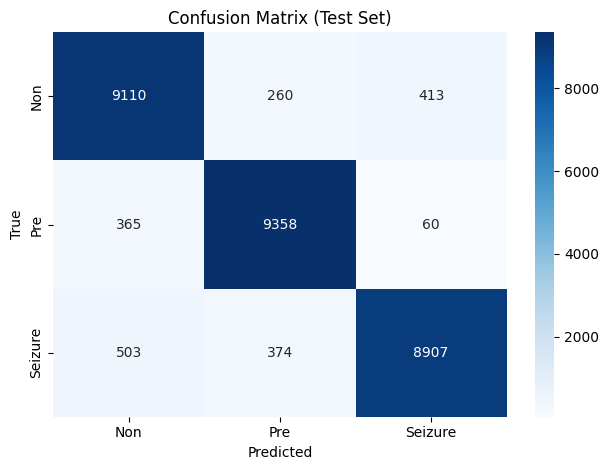

In [7]:
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ---------- Training ----------
def train_xgboost(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # Train-validation-test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # ✅ XGBoost Classifier
    clf = XGBClassifier(
        n_estimators=500,             # Number of boosting rounds
        max_depth=10,                 # Controls tree complexity (try 6–12)
        learning_rate=0.05,           # Lower = more conservative learning
        subsample=0.8,                # Row sampling like RF's bagging
        colsample_bytree=0.8,         # Feature sampling like RF's max_features
        gamma=1,                      # Minimum loss reduction (like RF min_samples_split)
        min_child_weight=5,           # Controls overfitting (like min_samples_leaf)
        reg_alpha=1,                  # L1 regularization (sparse features)
        reg_lambda=1,                 # L2 regularization
        objective='multi:softmax',    # Since you have 3 classes
        num_class=3,                  # For multi-class classification
        eval_metric='mlogloss',       # or 'merror' for accuracy
        use_label_encoder=False,
        random_state=42
    )

    # 🏋️ Train model
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    annotation_json = "zenodo_annotations.json"
    edf_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"

    print(f"Reading seizure metadata from: {annotation_json}")
    summary_data = parse_zenodo_json(annotation_json)
    print(f"Total annotated seizure segments: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_xgboost(X, y)
    else:
        print("Dataset build failed.")

Reading seizure metadata from: zenodo_annotations.json
Total annotated seizure segments: 429
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to er

c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [21:27:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       0.94      1.00      0.97     70438
 Pre-Seizure       0.97      0.97      0.97     70438
     Seizure       1.00      0.94      0.97     70438

    accuracy                           0.97    211314
   macro avg       0.97      0.97      0.97    211314
weighted avg       0.97      0.97      0.97    211314


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.93      0.99      0.96     17610
 Pre-Seizure       0.96      0.96      0.96     17610
     Seizure       0.99      0.93      0.96     17609

    accuracy                           0.96     52829
   macro avg       0.96      0.96      0.96     52829
weighted avg       0.96      0.96      0.96     52829


🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.93      0.99      0.96      9783
 Pre-Seizure       0.96      0.96      0.96      9783
     Seizure       0

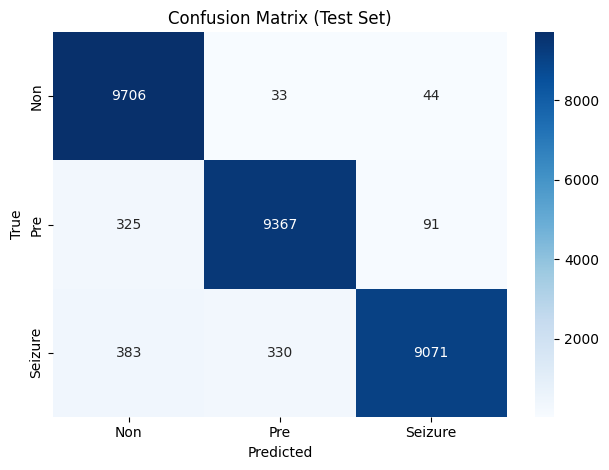

In [8]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import os


def train_stacked_model(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Balance dataset using SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # Split dataset
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # Base model 1: Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )

    # Base model 2: XGBoost
    xgb_base = XGBClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,
        min_child_weight=5,
        reg_alpha=1,
        reg_lambda=1,
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # Meta model: XGBoost
    xgb_meta = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # Build stacking classifier
    clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb_base)],
        final_estimator=xgb_meta,
        passthrough=True,  # include original features
        n_jobs=-1
    )



    # Train model
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    annotation_json = "zenodo_annotations.json"
    edf_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"

    print(f"Reading seizure metadata from: {annotation_json}")
    summary_data = parse_zenodo_json(annotation_json)
    print(f"Total annotated seizure segments: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_stacked_model(X, y)
    else:
        print("Dataset build failed.")

Reading seizure metadata from: zenodo_annotations.json
Total annotated seizure segments: 429
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to er

c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       0.94      1.00      0.97     70438
 Pre-Seizure       0.98      0.97      0.98     70438
     Seizure       1.00      0.96      0.98     70438

    accuracy                           0.97    211314
   macro avg       0.98      0.97      0.97    211314
weighted avg       0.98      0.97      0.97    211314


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.93      0.99      0.96     17610
 Pre-Seizure       0.98      0.96      0.97     17610
     Seizure       0.99      0.94      0.96     17609

    accuracy                           0.96     52829
   macro avg       0.97      0.96      0.96     52829
weighted avg       0.97      0.96      0.96     52829


🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.93      0.99      0.96      9783
 Pre-Seizure       0.98      0.96      0.97      9783
     Seizure       0

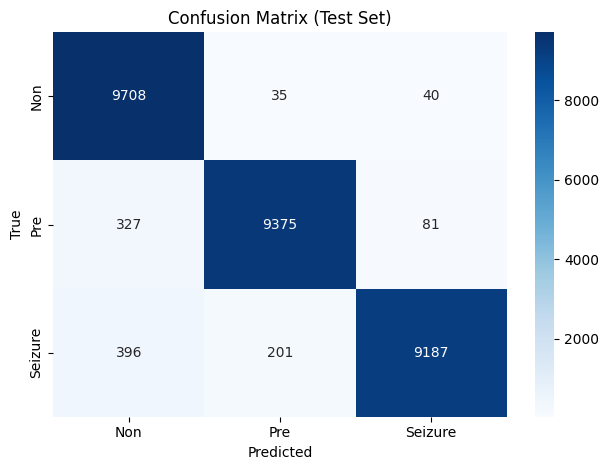

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

def train_stacked_rf_lgbm(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Balance dataset using SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Split data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🧼 Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 🌲 Base model 1: Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )

    # 🌿 Base model 2: LightGBM
    lgbm = LGBMClassifier(
        n_estimators=500,         # align with RF
        learning_rate=0.03,       # more conservative for better generalization
        max_depth=15,             # closer to RF's unbounded trees
        num_leaves=50,            # more expressive leaves
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )

    # 🚀 Meta model: XGBoost
    xgb_meta = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # 🧠 Stacking
    clf = StackingClassifier(
        estimators=[('rf', rf), ('lgbm', lgbm)],
        final_estimator=xgb_meta,
        passthrough=True,  # includes original features
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    annotation_json = "zenodo_annotations.json"
    edf_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"

    print(f"Reading seizure metadata from: {annotation_json}")
    summary_data = parse_zenodo_json(annotation_json)
    print(f"Total annotated seizure segments: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_stacked_rf_lgbm(X, y)
    else:
        print("Dataset build failed.")

Reading seizure metadata from: zenodo_annotations.json
Total annotated seizure segments: 429
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to er

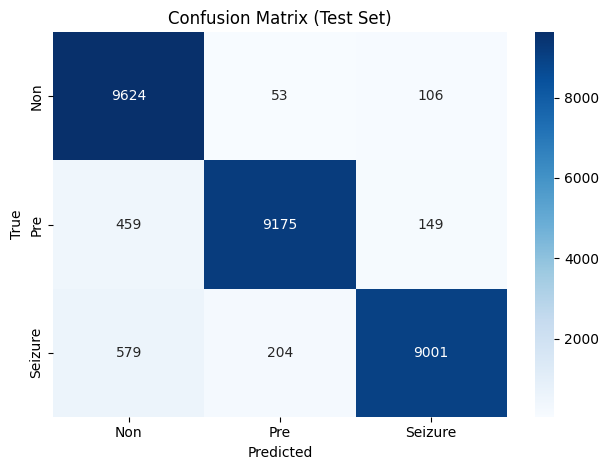

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

def train_bagging_dt(X, y):
    print("\n🔄 Original label distribution:", np.bincount(y))

    # ⚖️ Apply SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Train/Validation/Test Split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🌳 Base Estimator: Decision Tree
    base_dt = DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    # 🧠 Bagging Ensemble
    clf = BaggingClassifier(
        estimator=base_dt,           # 👈 updated parameter name
        n_estimators=100,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # 🏋️ Fit the model
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    annotation_json = "zenodo_annotations.json"
    edf_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"

    print(f"Reading seizure metadata from: {annotation_json}")
    summary_data = parse_zenodo_json(annotation_json)
    print(f"Total annotated seizure segments: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_bagging_dt(X, y)
    else:
        print("Dataset build failed.")